In [1]:
import pandas as pd

import numpy as np

from datetime import datetime
from datetime import timedelta

import pytz
import sys
import pickle

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, median_absolute_error, r2_score, explained_variance_score

import seaborn as sns

import plotly.graph_objects as go

from Long_Short_Term_Memory import Long_Short_Term_Memory

from Optimize_Portfolio import PortfolioManagement

import MetaTrader5 as mt5

import ta

from scipy.stats import zscore

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers

In [57]:
gc_o_TIME_ZONE = pytz.timezone("Etc/UTC")
gc_dt_FROM = datetime(2021, 11, 15, tzinfo=gc_o_TIME_ZONE)
gc_dt_TO = datetime(2021, 11, 19, tzinfo=gc_o_TIME_ZONE)
def dfGetMarketTicks(sSymbol):
    if not mt5.initialize():
        print("initialize() failed, error code =", mt5.last_error())
        sys.exit()

    aSymbolInfo = mt5.symbol_info(sSymbol)
    if not aSymbolInfo:
        print("symbol_info() failed, error code =", mt5.last_error())
        sys.exit()
    
    dfTicks = mt5.copy_ticks_range(
        sSymbol, 
        gc_dt_FROM, 
        gc_dt_TO, 
        mt5.COPY_TICKS_INFO)

    if len(dfTicks) == 0:
        print("copy_ticks_range() failed, error code =", mt5.last_error())
        sys.exit()

    mt5.shutdown()
    
    dfTicks = pd.DataFrame(dfTicks)

    dfTicks['timestamp'] = pd.to_datetime(dfTicks['time_msc'], unit= "ms")
    dfTicks.set_index('timestamp', inplace=True)
        
    
    return dfTicks 

def dfGetMarketOhlc(sSymbol):
    if not mt5.initialize():
        print("initialize() failed, error code =", mt5.last_error())
        sys.exit()

    aSymbolInfo = mt5.symbol_info(sSymbol)
    if not aSymbolInfo:
        print("symbol_info() failed, error code =", mt5.last_error())
        sys.exit()
    
    dfOhlc = mt5.copy_rates_range(
        sSymbol,
        mt5.TIMEFRAME_M1,
        gc_dt_FROM, 
        gc_dt_TO,
    )

    if len(dfOhlc) == 0:
        print("copy_rates_range() failed, error code =", mt5.last_error())
        sys.exit()

    mt5.shutdown()
    
    dfOhlc = pd.DataFrame(dfOhlc)

    dfOhlc['timestamp'] = pd.to_datetime(dfOhlc['time'], unit= "s")
    dfOhlc.set_index('timestamp', inplace=True)
        
    
    return dfOhlc 


In [3]:
def dfScaleData(sSubModelName, sScalerName,dfTrain,dfValidation, dfTest, bIsStandard = True):
    sScalersDirectory = os.path.join(sSubModelName , "__scalers__")
    if bIsStandard == True:
        oScaler = StandardScaler()
    else:
        oScaler = MinMaxScaler()

    oScaler.fit(dfTrain)

    aScaledTrain = oScaler.transform(dfTrain)
    aScaledValidation = oScaler.transform(dfValidation)
    aScaledTest = oScaler.transform(dfTest)

    dfScaledTrain = pd.DataFrame(aScaledTrain, columns = dfTrain.columns, index = dfTrain.index)
    dfScaledValidation = pd.DataFrame(aScaledValidation, columns = dfValidation.columns, index = dfValidation.index)
    dfScaledTest = pd.DataFrame(aScaledTest, columns = dfTest.columns, index = dfTest.index)

    sScalerFilePath =os.path.join(sScalersDirectory, sScalerName + ".sav")
    os.makedirs(os.path.dirname(sScalerFilePath), exist_ok=True)
    pickle.dump(oScaler, open(sScalerFilePath, 'wb'))
    
    
    return dfScaledTrain, dfScaledValidation, dfScaledTest

In [4]:
sSymbol = "USDCAD"

In [5]:
dfTicks = dfGetMarketTicks(sSymbol)

In [58]:
dfOhlc = dfGetMarketOhlc(sSymbol)

,time,open,high,low,close,tick_volume,spread,real_volume
timestamp,,,,,,,,
2021-11-15 00:00:00,1636934400,1.25407,1.25407,1.25407,1.25407,7,124,1050000
2021-11-15 00:01:00,1636934460,1.25407,1.25407,1.25407,1.25407,2,67,300000
2021-11-15 00:02:00,1636934520,1.25417,1.25420,1.25417,1.25420,6,67,900000
2021-11-15 00:04:00,1636934640,1.25420,1.25420,1.25420,1.25420,4,147,600000
2021-11-15 00:05:00,1636934700,1.25420,1.25420,1.25418,1.25419,6,67,900000
...,...,...,...,...,...,...,...,...
2021-11-18 23:56:00,1637279760,1.25980,1.25986,1.25980,1.25984,96,20,14400000
2021-11-18 23:57:00,1637279820,1.25984,1.25984,1.25975,1.25977,47,26,7050000
2021-11-18 23:58:00,1637279880,1.25977,1.25978,1.25955,1.25969,184,26,27600000


In [6]:
dfTicks = dfTicks.reset_index().drop_duplicates(subset = ["timestamp"]).set_index('timestamp').sort_index()

In [7]:
dfTicks["bid_change"] = dfTicks["bid"].shift(-1) - dfTicks["bid"]
dfTicks["ask_change"] = dfTicks["ask"].shift(-1) - dfTicks["ask"]
dfTicks.drop(
    dfTicks[(dfTicks["bid_change"] == 0) & (dfTicks["ask_change"] == 0)].index,
    inplace=True
)
dfTicks["interarrival_time"] = dfTicks["time_msc"].shift(-1) - dfTicks["time_msc"]
dfTicks["bid_change"] = dfTicks["bid"].shift(-1) - dfTicks["bid"]
dfTicks["ask_change"] = dfTicks["ask"].shift(-1) - dfTicks["ask"]
dfTicks["ask_next"] = dfTicks["ask"].shift(-1)
dfTicks["bid_next"] = dfTicks["bid"].shift(-1)

In [8]:
dfTicks["hour"] = dfTicks.index.hour
dfTicks["minute"] = dfTicks.index.minute
dfTicks["second"] = dfTicks.index.second
dfTicks["spread"] = dfTicks["ask"] - dfTicks["bid"]

In [9]:
dfTicks.drop(["time_msc", "volume" , "flags", "volume_real", "last", "time"], axis = 1 , inplace = True)

In [10]:
dfTicks.dropna(inplace = True)

In [27]:
dfTicks.head(10)

,bid,ask,bid_change,ask_change,interarrival_time,ask_next,bid_next,hour,minute,second,spread
timestamp,,,,,,,,,,,
2021-11-15 00:00:05.029,1.25407,1.25545,0.00000,-0.00014,71144.0,1.25531,1.25407,0,0,5,0.00138
2021-11-15 00:01:16.173,1.25407,1.25531,0.00010,-0.00047,47052.0,1.25484,1.25417,0,1,16,0.00124
2021-11-15 00:02:03.225,1.25417,1.25484,-0.00010,0.00047,2.0,1.25531,1.25407,0,2,3,0.00067
2021-11-15 00:02:03.227,1.25407,1.25531,0.00012,-0.00045,130.0,1.25486,1.25419,0,2,3,0.00124
2021-11-15 00:02:03.357,1.25419,1.25486,0.00001,0.00001,29302.0,1.25487,1.25420,0,2,3,0.00067
2021-11-15 00:02:32.659,1.25420,1.25487,-0.00001,-0.00001,644.0,1.25486,1.25419,0,2,32,0.00067
2021-11-15 00:02:33.303,1.25419,1.25486,0.00001,0.00001,25393.0,1.25487,1.25420,0,2,33,0.00067
2021-11-15 00:02:58.696,1.25420,1.25487,-0.00020,0.00061,39595.0,1.25548,1.25400,0,2,58,0.00067
2021-11-15 00:03:38.291,1.25400,1.25548,0.00000,-0.00001,26086.0,1.25547,1.25400,0,3,38,0.00148


# INTERARRIVAL TIME

In [12]:
# dfInterarrivalTime = dfTicks["interarrival_time"]

## Remove Noisy Data

In [13]:
# aZScores=abs(zscore(dfInterarrivalTime , nan_policy="omit"))
# dfInterarrivalTime = dfInterarrivalTime[(aZScores<3)]

## Chi Square Test for Exponential Distribution

In [14]:
# sns.histplot(dfInterarrivalTime)

In [15]:
# from scipy.stats import chisquare
# fMu= dfInterarrivalTime.mean()
# dfPossionExpected = np.random.exponential(fMu, size=len(dfInterarrivalTime))
# sns.histplot(dfPossionExpected)
# chisquare(dfInterarrivalTime, dfPossionExpected)

# DEEP LEARNING MODEL

In [16]:
sModelName = os.path.join(sSymbol , "__deep learning model__")

## Preprocessing

In [17]:
dfInput = pd.DataFrame()
for i in range(-10, 0):
    dfInput["interarrival_time_" + str(i)] = dfTicks["interarrival_time"].shift(-i)
    dfInput["bid_" + str(i)] = dfTicks["bid"].shift(-i)
    dfInput["ask_" + str(i)] = dfTicks["ask"].shift(-i)
    dfInput["spread_" + str(i)] = dfTicks["interarrival_time"].shift(-i)
    dfInput["hour_" + str(i)] = dfTicks["bid"].shift(-i)
    dfInput["minute_" + str(i)] = dfTicks["ask"].shift(-i)
    dfInput["second_" + str(i)] = dfTicks["ask"].shift(-i)


In [18]:
dfOutput = pd.DataFrame()
for i in range(0, 1):
    dfOutput["ask" + str(i)] = dfTicks["ask"].shift(-i)

In [19]:
dfMerged = dfInput.join(dfOutput, how= "inner")
dfMerged.dropna(inplace=True)
dfInput = dfMerged[dfInput.columns]
dfOutput = dfMerged[dfOutput.columns]

### Remove Noisy Data

In [ ]:
# aZScores=abs(zscore(dfOutput , nan_policy="omit"))

# dfOutput = dfOutput[(aZScores<12).all(axis=1)]
# dfInput = dfInput[(aZScores<12).all(axis=1)]

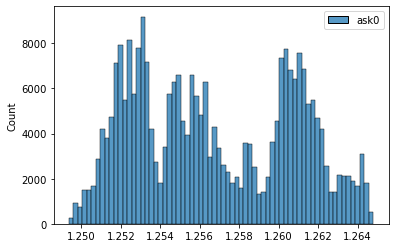

In [20]:
sns.histplot(dfOutput)

### Split Data

In [21]:
gc_dec_TRAINING_RATIO = 0.6
gc_dec_VALIDATION_RATIO = 0.2
gc_dec_TEST_RATIO = 0.2

dfInputTrainValidation, dfInputTest, dfOutputTrainValidation, dfOutputTest = train_test_split(
    dfInput,
    dfOutput,
    test_size=gc_dec_TEST_RATIO,
    shuffle=False)

dfInputTrain, dfInputValidation, dfOutputTrain, dfOutputValidation = train_test_split(
    dfInputTrainValidation,
    dfOutputTrainValidation,
    test_size=(1/(1 -gc_dec_TEST_RATIO))-1,
    shuffle=False)


dfInputTrain = dfInputTrain.astype(float)
dfInputValidation = dfInputValidation.astype(float)
dfInputTest = dfInputTest.astype(float)
dfOutputTrain = dfOutputTrain.astype(float)
dfOutputValidation = dfOutputValidation.astype(float)
dfOutputTest = dfOutputTest.astype(float)

### Scale Data

In [22]:
dfScaledInputTrain, dfScaledInputValidation, dfScaledInputTest = dfScaleData(sModelName,
                                                                             "input", 
                                                                             dfInputTrain,
                                                                             dfInputValidation, 
                                                                             dfInputTest)

dfScaledOutputTrain, dfScaledOutputValidation, dfScaledOutputTest = dfScaleData(sModelName,
                                                                                "output", 
                                                                                dfOutputTrain,
                                                                                dfOutputValidation, 
                                                                                dfOutputTest,
                                                                               False)

## Train

### Set Hyperparameters

In [23]:
iBatchSize = 1024

oLrSchedule = keras.optimizers.schedules.ExponentialDecay(
    1e-05, decay_steps=100000, decay_rate=0.50, staircase=True
)


oOptimizer = tf.keras.optimizers.Adam(learning_rate=1e-05)

oEarlyStop = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 0 , 
    patience = 20, 
    restore_best_weights = True)
iEpochSize = 10000

### Build Model

In [24]:
oInputRates = keras.Input(
    shape=(
        dfScaledInputTrain.shape[1]), 
    name="aRates")

aW = Dense((200))(oInputRates)
aW = Dense((200), activation = "relu")(aW)
aW = Dense((200), activation = "relu")(aW)
aOutputRegression = Dense(1, name = "Regression", activation = "relu")(aW)

oPredictiveModel = keras.Model(
    inputs=oInputRates, 
    outputs=aOutputRegression
)

### Compile Model

In [25]:
oPredictiveModel.compile(optimizer=oOptimizer,
                         loss = tf.keras.losses.MeanSquaredError()
                        )


### Fit Model

Epoch 1/10000
159/159 [==============================] - 1s 5ms/step - loss: 0.2457 - val_loss: 0.2177
Epoch 2/10000
159/159 [==============================] - 1s 4ms/step - loss: 0.0423 - val_loss: 0.2420
Epoch 3/10000
159/159 [==============================] - 1s 4ms/step - loss: 0.0192 - val_loss: 0.1162
Epoch 4/10000
159/159 [==============================] - 1s 4ms/step - loss: 0.0139 - val_loss: 0.0783
Epoch 5/10000
159/159 [==============================] - 1s 4ms/step - loss: 0.0115 - val_loss: 0.0728
Epoch 6/10000
159/159 [==============================] - 1s 4ms/step - loss: 0.0099 - val_loss: 0.0624
Epoch 7/10000
159/159 [==============================] - 1s 4ms/step - loss: 0.0086 - val_loss: 0.0572
Epoch 8/10000
159/159 [==============================] - 1s 4ms/step - loss: 0.0075 - val_loss: 0.0495
Epoch 9/10000
159/159 [==============================] - 1s 4ms/step - loss: 0.0065 - val_loss: 0.0451
Epoch 10/10000
159/159 [==============================] - 1s 4ms/step - l

159/159 [==============================] - 1s 4ms/step - loss: 1.7909e-04 - val_loss: 2.6704e-04
Epoch 77/10000
159/159 [==============================] - 1s 4ms/step - loss: 1.7613e-04 - val_loss: 2.3115e-04
Epoch 78/10000
159/159 [==============================] - 1s 4ms/step - loss: 1.7201e-04 - val_loss: 2.1886e-04
Epoch 79/10000
159/159 [==============================] - 1s 4ms/step - loss: 1.6927e-04 - val_loss: 3.0797e-04
Epoch 80/10000
159/159 [==============================] - 1s 4ms/step - loss: 1.6884e-04 - val_loss: 3.0594e-04
Epoch 81/10000
159/159 [==============================] - 1s 4ms/step - loss: 1.6593e-04 - val_loss: 2.1176e-04
Epoch 82/10000
159/159 [==============================] - 1s 4ms/step - loss: 1.6240e-04 - val_loss: 2.0234e-04
Epoch 83/10000
159/159 [==============================] - 1s 4ms/step - loss: 1.5987e-04 - val_loss: 2.1680e-04
Epoch 84/10000
159/159 [==============================] - 1s 4ms/step - loss: 1.5562e-04 - val_loss: 1.9474e-04
Epoch 8

Epoch 149/10000
159/159 [==============================] - 1s 4ms/step - loss: 7.6153e-05 - val_loss: 1.2559e-04
Epoch 150/10000
159/159 [==============================] - 1s 4ms/step - loss: 7.4130e-05 - val_loss: 1.0278e-04
Epoch 151/10000
159/159 [==============================] - 1s 4ms/step - loss: 7.5222e-05 - val_loss: 1.0881e-04
Epoch 152/10000
159/159 [==============================] - 1s 4ms/step - loss: 7.6294e-05 - val_loss: 9.8291e-05
Epoch 153/10000
159/159 [==============================] - 1s 4ms/step - loss: 7.4556e-05 - val_loss: 1.4982e-04
Epoch 154/10000
159/159 [==============================] - 1s 4ms/step - loss: 7.4456e-05 - val_loss: 9.7938e-05
Epoch 155/10000
159/159 [==============================] - 1s 4ms/step - loss: 7.2984e-05 - val_loss: 9.1244e-05
Epoch 156/10000
159/159 [==============================] - 1s 4ms/step - loss: 7.2204e-05 - val_loss: 1.0108e-04
Epoch 157/10000
159/159 [==============================] - 1s 4ms/step - loss: 7.1681e-05 - val_

159/159 [==============================] - 1s 4ms/step - loss: 5.0206e-05 - val_loss: 7.7537e-05
Epoch 222/10000
159/159 [==============================] - 1s 4ms/step - loss: 4.7873e-05 - val_loss: 7.0483e-05
Epoch 223/10000
159/159 [==============================] - 1s 4ms/step - loss: 4.7037e-05 - val_loss: 9.0278e-05
Epoch 224/10000
159/159 [==============================] - 1s 4ms/step - loss: 4.8135e-05 - val_loss: 8.1850e-05
Epoch 225/10000
159/159 [==============================] - 1s 4ms/step - loss: 4.6558e-05 - val_loss: 8.5054e-05
Epoch 226/10000
159/159 [==============================] - 1s 4ms/step - loss: 4.5629e-05 - val_loss: 5.9422e-05
Epoch 227/10000
159/159 [==============================] - 1s 4ms/step - loss: 4.6837e-05 - val_loss: 5.7909e-05
Epoch 228/10000
159/159 [==============================] - 1s 4ms/step - loss: 4.6802e-05 - val_loss: 8.0354e-05
Epoch 229/10000
159/159 [==============================] - 1s 4ms/step - loss: 4.5252e-05 - val_loss: 5.8692e-05

159/159 [==============================] - 1s 4ms/step - loss: 3.3375e-05 - val_loss: 4.4102e-05
Epoch 294/10000
159/159 [==============================] - 1s 4ms/step - loss: 3.4394e-05 - val_loss: 4.5128e-05
Epoch 295/10000
159/159 [==============================] - 1s 4ms/step - loss: 3.3738e-05 - val_loss: 4.5290e-05
Epoch 296/10000
159/159 [==============================] - 1s 4ms/step - loss: 3.3876e-05 - val_loss: 4.5644e-05
Epoch 297/10000
159/159 [==============================] - 1s 4ms/step - loss: 3.3329e-05 - val_loss: 7.0199e-05
Epoch 298/10000
159/159 [==============================] - 1s 4ms/step - loss: 3.3450e-05 - val_loss: 5.1190e-05
Epoch 299/10000
159/159 [==============================] - 1s 4ms/step - loss: 3.2930e-05 - val_loss: 5.0181e-05
Epoch 300/10000
159/159 [==============================] - 1s 4ms/step - loss: 3.2772e-05 - val_loss: 8.1976e-05
Epoch 301/10000
159/159 [==============================] - 1s 4ms/step - loss: 3.2995e-05 - val_loss: 4.4189e-05

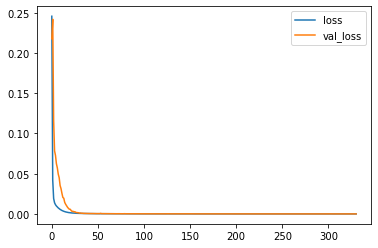

In [26]:
oPredictiveModel.fit(
    dfScaledInputTrain, 
    dfScaledOutputTrain, 
    epochs=iEpochSize, 
    batch_size=iBatchSize, 
    verbose=1, 
    validation_data= (dfScaledInputValidation, dfScaledOutputValidation),
    validation_batch_size= iBatchSize,
    callbacks=[oEarlyStop]
)

oPredictiveModel.save_weights(sModelName)

pd.DataFrame(oPredictiveModel.history.history).plot()

## Test

In [28]:
oPredictiveModel.load_weights(sModelName)

aPrediction = oPredictiveModel.predict(dfScaledInputTest)

sOutputScalerPath = os.path.join(sModelName , "__scalers__")
sOutputScalerPath = os.path.join(sOutputScalerPath , "output" + ".sav")
oScalerOutput = pickle.load(open(sOutputScalerPath, 'rb'))
aPrediction = oScalerOutput.inverse_transform(aPrediction)

dfPrediction = pd.DataFrame(aPrediction, index = dfScaledOutputTest.index)
dfPrediction.columns = dfOutput.columns

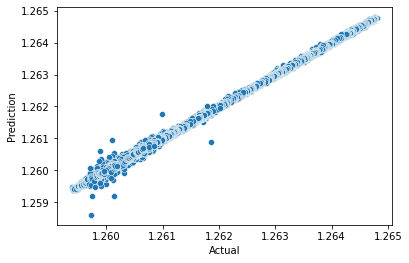

In [29]:
dfTestComparision = pd.DataFrame(dfPrediction.iloc[:,0])
dfTestComparision = dfTestComparision.join(dfOutputTest.iloc[:,0], how = "inner", lsuffix="prediction")
dfTestComparision.columns = ["Prediction", "Actual"]

sns.scatterplot(data = dfTestComparision, x = "Actual", y ="Prediction")

0.8317766398728657


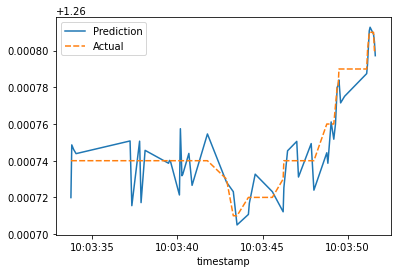

In [36]:
iFrom = 300
iTo = 350
print(r2_score(dfOutputTest.iloc[iFrom:iTo], dfPrediction.iloc[iFrom:iTo]))
sns.lineplot(data = dfTestComparision.iloc[iFrom:iTo])

In [32]:
y_pred = dfPrediction.iloc[:, 0]
y_true = dfOutputTest.iloc[:, 0]
aMetrics = [
        ('mean absolute error', mean_absolute_error(y_true, y_pred)),
        ('median absolute error', median_absolute_error(y_true, y_pred)),
        ('mean squared error', mean_squared_error(y_true, y_pred)),
        ('max error', max_error(y_true, y_pred)),
        ('r2 score', r2_score(y_true, y_pred)),
        ('explained variance score', explained_variance_score(y_true, y_pred))
    ]

print('Metrics for regression:')
for metric_name, metric_value in aMetrics:
    print(f'{metric_name:>25s}: {metric_value: >20.3f}')

Metrics for regression:
      mean absolute error:                0.000
    median absolute error:                0.000
       mean squared error:                0.000
                max error:                0.001
                 r2 score:                1.000
 explained variance score:                1.000


In [ ]:
y_pred = dfPrediction.iloc[:, 1]
y_true = dfOutputTest.iloc[:, 1]
print(classification_report(y_true, y_pred, zero_division = 0))

In [ ]:
y_pred = dfPrediction.iloc[:, 0]
y_true = dfOutputTest.iloc[:, 0]
print(classification_report(y_true, y_pred, zero_division = 0))

# REFERENCES

https://www.tensorflow.org/guide/keras/train_and_evaluate#passing_data_to_multi-input_multi-output_models

https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/

https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/

https://towardsdatascience.com/customize-loss-function-to-make-lstm-model-more-applicable-in-stock-price-prediction-b1c50e50b16c

https://keras.io/getting_started/faq/